In [1]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [2]:
path = Config().data_path()/'mnist'

In [3]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz')]

In [4]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1') 
    # _ = don't care about the test set

(50000, 784)

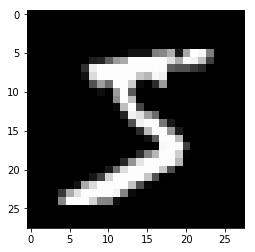

In [5]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

numpy arrays to tensors:

In [6]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape # n = number of items (images), c = number of columns (number of pixels flattened out) 
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [7]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

# create data loaders with DataBunch
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [8]:
x,y = next(iter(data.train_dl))
x.shape,y.shape
# x is 64 items/images as expected, 784 pixels. 

(torch.Size([64, 784]), torch.Size([64]))

In [9]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [10]:
model = Mnist_Logistic().cuda()

In [11]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [12]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [13]:
model(x).shape

torch.Size([64, 10])

In [14]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

784 dimensions to 10 dimensions

In [15]:
lr=2e-2

In [16]:
loss_func = nn.CrossEntropyLoss()

In [17]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [18]:
losses = [update(x,y,lr) for x,y in data.train_dl]
losses[:3], losses[778:]

([2.356104850769043, 2.3006913661956787, 2.3072879314422607],
 [0.5999253988265991, 0.45241156220436096, 0.6058179140090942])

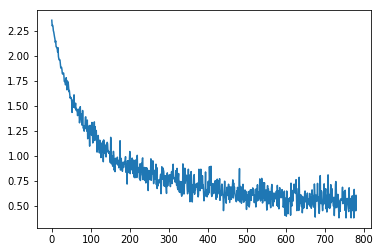

In [19]:
plt.plot(losses);

Create a neural net yourself:

In [20]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [21]:
model = Mnist_NN().cuda()

In [22]:
losses = [update(x,y,lr) for x,y in data.train_dl]

In [23]:
losses[:3], losses[778:]

([2.2973673343658447, 2.2823195457458496, 2.2813618183135986],
 [0.5448324680328369, 0.3970164656639099, 0.47281119227409363])

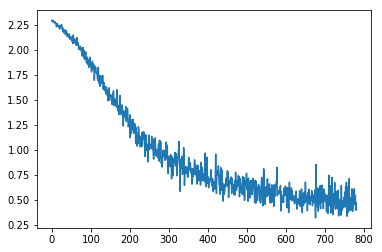

In [24]:
plt.plot(losses);

In [25]:
model = Mnist_NN().cuda()

What about changing the optimisation? Replace SGD with Adam:

In [26]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

Because of the optimisation, we need to add a new learning rate. Using the previous lr would cause divergence. 

In [27]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

In [28]:
losses[:3], losses[778:]

([2.3228609561920166, 2.290684700012207, 2.279414415359497],
 [0.23458243906497955, 0.1608944684267044, 0.38645878434181213])

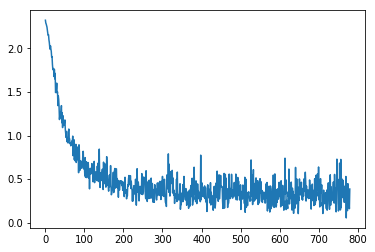

In [29]:
plt.plot(losses);

The loss is down to 0.5 by epoch 200

## Using fastai
With learning and the plotting is smoothed to make it easier to see what is going on.

In [30]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


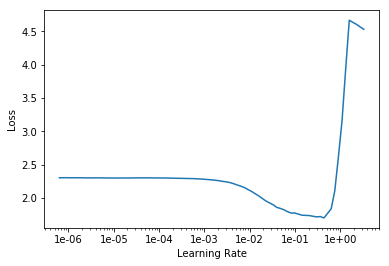

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.143458,0.133417,0.959700


Plot the learning rate per batch. 

Learning Rate (the left plot) starts low, increases and then decreases again per epoch. 

Momentum (the right plot) 

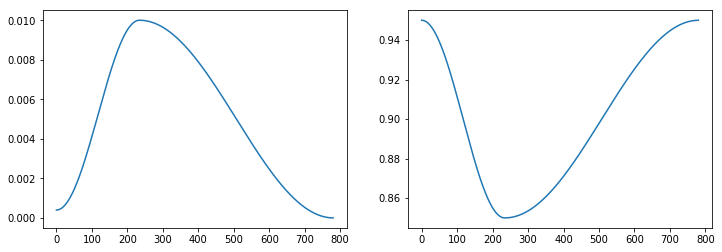

In [34]:
learn.recorder.plot_lr(show_moms=True)

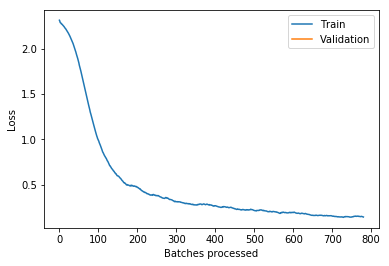

In [33]:
learn.recorder.plot_losses()

## fin